<a href="https://colab.research.google.com/github/kiakass/recommendation/blob/main/CF_recommendation_KNN_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#!pip install surprise

In [ ]:
from surprise import Reader, Dataset

In [ ]:
movies_fn = ('https://raw.githubusercontent.com/kiakass/share/master/movies.csv')   # 9,125 건, 
ratings_fn = ('https://raw.githubusercontent.com/kiakass/share/master/ratings.csv') # 100,004 건

In [ ]:
movies=pd.read_csv(movies_fn)
ratings=pd.read_csv(ratings_fn)

### # rating-movie & data join view 

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [ ]:
pd.merge(ratings, movies, on='movieId')

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama
...,...,...,...,...,...,...
99999,664,64997,2.5,1343761859,War of the Worlds (2005),Action|Sci-Fi
100000,664,72380,3.5,1344435977,"Box, The (2009)",Drama|Horror|Mystery|Sci-Fi|Thriller
100001,665,129,3.0,995232528,Pie in the Sky (1996),Comedy|Romance
100002,665,4736,1.0,1010197684,Summer Catch (2001),Comedy|Drama|Romance


### 특정 user 기준 data 보기

In [ ]:
ratings[(ratings['userId'] == 264)].sort_values('rating',ascending=False).head()

,userId,movieId,rating,timestamp
36773,264,39,5.0,995664962
36785,264,1097,5.0,995664664
36800,264,2406,5.0,995664995
36799,264,2248,5.0,995664866
36797,264,2125,5.0,995665027


In [ ]:
df_o=ratings[(ratings['userId'] == 264)&(ratings['movieId'] == 4280)]

In [ ]:
pd.merge(df_o,movies, on='movieId').head()

,userId,movieId,rating,timestamp,title,genres
0,264,4280,4.0,995664947,"World According to Garp, The (1982)",Comedy|Drama|Romance


In [ ]:
# user 별로 얼마나 rating을 하였는지 ?
# 데이터프레임에서 한 컬럼만 뽑아낸 시리즈를 종류별로 카운트하고, 인덱스에 따라 내림차순 정렬
data = ratings['rating'].value_counts().sort_index(ascending=True)
data_g = ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating',ascending=False)
data_g

,userId,rating
546,547,2391
563,564,1868
623,624,1735
14,15,1700
72,73,1610
...,...,...
295,296,20
288,289,20
248,249,20
220,221,20


### # 별점(rating) Data 분포

Text(0.5, 1.0, 'Number of ratings per user.')

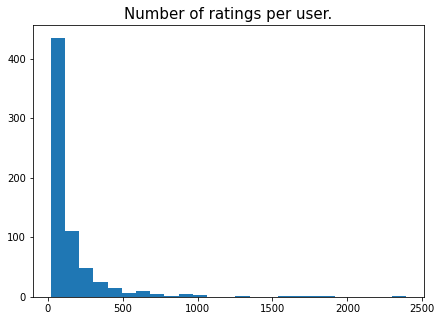

In [ ]:
plt.figure(figsize=(7,5))
a=plt.hist(data_g['rating'],25)
plt.title('Number of ratings per user.',fontsize=15)

In [ ]:
data

0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: rating, dtype: int64

Text(0.5, 1.0, 'Number of movies by ratings.')

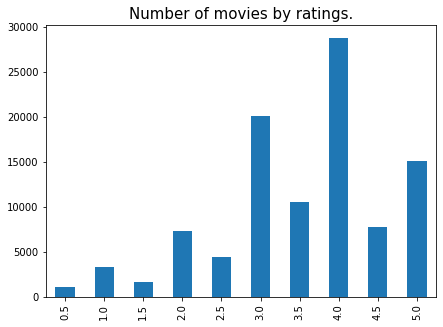

In [ ]:
plt.figure(figsize=(7,5))
data = ratings['rating'].value_counts().sort_index(ascending=True)
data.plot.bar()
plt.title('Number of movies by ratings.',fontsize=15)

### Data 처리

In [ ]:
#count()까지 Series타입이고, reset_index()까지 해서 dataframe이 된다.
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating',ascending=False)

,userId,rating
546,547,2391
563,564,1868
623,624,1735
14,15,1700
72,73,1610
...,...,...
295,296,20
288,289,20
248,249,20
220,221,20


In [ ]:
min_movie_ratings = 5
filter_movies = ratings['movieId'].value_counts() >= min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

ratings_new = ratings[ratings['movieId'].isin(filter_movies)]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(100004, 4)
The new data frame shape:	(90072, 4)


In [ ]:
reader= Reader(rating_scale=(0.5,5.0))

In [ ]:
reader

In [ ]:
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

In [ ]:
data

In [ ]:
reader = Reader(rating_scale=(1,5)) # rating_scale을 명시해주는 코드.
data = Dataset.load_from_df(ratings_new[['userId', 'movieId', 'rating']], reader)

https://datart.tistory.com/11

### SVD, KNN 성능비교 

In [ ]:
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
# from sklearn.model_selection import cross_validate 사이킷런의 크로스벨리데이션이 아니다.
from surprise.model_selection import cross_validate


benchmark = []
# 모든 알고리즘을 literate화 시켜서 반복문을 실행시킨다.
#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
for algorithm in [SVD(),KNNBasic()]:
    
    # 교차검증을 수행하는 단계.
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # 결과 저장과 알고리즘 이름 추가.
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.887749,3.684775,0.390386
KNNBasic,0.946270,0.121395,2.611458


In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.19576716423034668, 0.19860267639160156, 0.22784996032714844),
 'test_rmse': array([0.87453103, 0.88008225, 0.87786014]),
 'test_time': (0.33345460891723633, 0.16347503662109375, 0.34003376960754395)}

### User 시청 정보 요약 

In [ ]:
# userId 시청 영화 확인
def userId_wtch_movies(userId,cnt):
    userId_genre=pd.DataFrame()
    userId_genre['genre_rating']=pd.merge(ratings[(ratings['userId'] == userId)],movies, on='movieId').groupby('genres')['rating'].mean()
    userId_genre['genre_cnt']=pd.merge(ratings[(ratings['userId'] == userId)],movies, on='movieId').groupby('genres')['rating'].count()
    userId_genre_r = userId_genre.sort_values('genre_cnt',ascending=False)
    
    userId_movie_l = \
    pd.merge(ratings[(ratings['userId'] == userId)].sort_values('rating',ascending=False).head(cnt),movies, on='movieId')
    
    return userId_genre_r, userId_movie_l

In [ ]:
genre,wtch=userId_wtch_movies(265,20)

print(genre.head(20) ,'\n')
wtch.drop(['timestamp'],axis=1)

                                  genre_rating  genre_cnt
genres                                                   
Drama                                 3.675000         40
Comedy|Drama|Romance                  4.230769         13
Drama|Romance                         3.900000         10
Drama|War                             3.800000         10
Comedy|Drama                          3.875000          8
Comedy                                3.714286          7
Drama|Mystery                         3.833333          6
Crime|Drama                           4.333333          6
Comedy|Romance                        4.250000          4
Action|Drama|War                      4.333333          3
Comedy|Drama|War                      4.000000          3
Drama|Romance|War                     4.333333          3
Drama|Western                         4.666667          3
Drama|Romance|Thriller                3.500000          2
Drama|Musical                         4.500000          2
Adventure|Dram

,userId,movieId,rating,title,genres
0,265,1944,5.0,From Here to Eternity (1953),Drama|Romance|War
1,265,936,5.0,Ninotchka (1939),Comedy|Romance
2,265,3418,5.0,Thelma & Louise (1991),Adventure|Crime|Drama
3,265,1079,5.0,"Fish Called Wanda, A (1988)",Comedy|Crime
4,265,1084,5.0,Bonnie and Clyde (1967),Crime|Drama
5,265,1096,5.0,Sophie's Choice (1982),Drama
6,265,1104,5.0,"Streetcar Named Desire, A (1951)",Drama
7,265,3201,5.0,Five Easy Pieces (1970),Drama
8,265,3200,5.0,"Last Detail, The (1973)",Comedy|Drama
9,265,1283,5.0,High Noon (1952),Drama|Western


### KNN

In [ ]:
from surprise import KNNBasic
reader= Reader(rating_scale=(0.5,5.0))

In [ ]:
reader = Reader(rating_scale=(1,5)) # rating_scale을 명시해주는 코드.
data = Dataset.load_from_df(ratings_new[['userId', 'movieId', 'rating']], reader)

In [ ]:
# User 영화 추출 함수
def recommand_movie(userId,cnt):
    userId=userId
    cnt=cnt
    
    # rating 에서 시청한 userId, movieId 추출
    df_movieid_for_uid=ratings[(ratings['userId'] == userId)][['userId','movieId']]
    
    
    # userId가 시청한 movieId 를 제외한 movieId를 추출
    df_movieid_for_uid_omit=movies[~movies['movieId'].isin(df_movieid_for_uid['movieId'])]
    recommand = df_movieid_for_uid_omit[['movieId']].values.reshape(-1)
    #print('ratings : ',ratings.shape,'df_movieid_for_uid :', df_movieid_for_uid.shape,df_movieid_for_uid_omit.shape, 'recommand :', recommand.shape,'\n')
    
    # 시청하지 않은 movieId의 점수를 예측함
    recm=pd.DataFrame(columns=['userId','movieId','x','rating','desc'])
    for j in recommand:
        a,b,c,d,e=algo.predict(userId,j,)
        e={'was_impossible':e['was_impossible']} # desc output 이상데이터처리
        k=pd.DataFrame({'userId':a,'movieId':b,'x':c,'rating':d,'desc':e}).reset_index()
        recm=recm.append(k)
    
    # rating 상위 20개 영화 추출
    recm = recm[['userId','movieId','rating']].sort_values('rating',ascending=False).head(cnt)
    print(recm)
    
    return recm

In [ ]:
# 알고리즘 : k-nearest neighbor (최근접이웃)
from surprise.model_selection import train_test_split
from surprise import accuracy

trainset, testset = train_test_split(data, test_size=0.25)
bsl_options = {'method': 'als',
               'n_epochs': 20,
               }
option = {'name' : 'pearson'}

algo = KNNBasic(bsl_options=bsl_options, sim_options=option)

# KNNBasic 알고리즘 수행
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9749


0.9749379804268979

In [ ]:
# prediction
algo.predict(265,3996,)

Prediction(uid=265, iid=3996, r_ui=None, est=3.6864076445135328, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
# 선호 영화 예측
recm1=recommand_movie(265,20)  # userId, cnt(추천콘텐츠갯수)

ratings :  (100004, 4) df_movieid_for_uid : (183, 2) (8942, 3) recommand : (8942,) 

  userId movieId  rating
0    265   97306     5.0
0    265   98124     5.0
0    265     937     5.0
0    265   27790     5.0
0    265    4616     5.0
0    265     422     5.0
0    265    2670     5.0
0    265   92535     5.0
0    265    4304     5.0
0    265     635     5.0
0    265   94466     5.0
0    265   26326     5.0
0    265    2327     5.0
0    265      72     5.0
0    265   86345     5.0
0    265   65261     5.0
0    265     178     5.0
0    265     116     5.0
0    265    1365     5.0
0    265  108979     5.0


In [ ]:
# 추천 영화 List
pd.merge(recm1, movies, on='movieId')

,userId,movieId,rating,title,genres
0,265,97306,5.0,Seven Psychopaths (2012),Comedy|Crime
1,265,98124,5.0,"Batman: The Dark Knight Returns, Part 1 (2012)",Action|Animation|Sci-Fi
2,265,937,5.0,Love in the Afternoon (1957),Comedy|Romance
3,265,27790,5.0,Millions (2004),Children|Comedy|Crime|Drama|Fantasy
4,265,4616,5.0,Lean on Me (1989),Drama
5,265,422,5.0,Blink (1994),Thriller
6,265,2670,5.0,Run Silent Run Deep (1958),War
7,265,92535,5.0,Louis C.K.: Live at the Beacon Theater (2011),Comedy
8,265,4304,5.0,Startup.com (2001),Documentary
9,265,635,5.0,"Family Thing, A (1996)",Comedy|Drama


In [ ]:
def cf_knn_pearson_recommand(userId, k_cnt, m_cnt):
    
    result=algo.get_neighbors(userId,k=k_cnt)
    print('k neighbor : ',result)
    
    rec_result=pd.DataFrame()
    
    # k_cnt 명의 user가 본 평점 5점인 영화중 n(m_cnt)개 영화를 찾음
    for k in result :
        #r1= 265
        max_rating=data.df[data.df['userId']==k]['rating'].max()
        rec_id=data.df[(data.df['rating']==max_rating) \
                       &(data.df['userId']==k)]['movieId'].head(m_cnt)
        for i in rec_id:
            k=movies[movies['movieId']==i]
            rec_result=rec_result.append(k)
        
        ## 시청한 영화를 제외함
        df_movieid_for_uid=ratings[(ratings['userId'] == userId)][['userId','movieId']]
        rec_result2 = rec_result[~rec_result['movieId'].isin(df_movieid_for_uid['movieId'])]

    return rec_result2

In [ ]:
# 추천 영화 리스트 - k-neighbors 들이 본 영화중 평점이 높은 영화 추출
recommand_movie_list = cf_knn_pearson_recommand(265,3,10)  # uid, k-neighbor, return movie no.
recommand_movie_list[['title','genres']]

k neighbor :  [54, 59, 90]


,title,genres
879,Dirty Dancing (1987),Drama|Musical|Romance
6387,Inside Man (2006),Crime|Drama|Thriller
6556,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller
6980,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
485,Blade Runner (1982),Action|Sci-Fi|Thriller
622,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
916,Wallace & Gromit: The Wrong Trousers (1993),Animation|Children|Comedy|Crime
977,"Godfather: Part II, The (1974)",Crime|Drama
4395,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
4809,All the President's Men (1976),Drama|Thriller


### SVD 추천 알고리즘

In [ ]:
# 알고리즘 : SVD 모델 training
from surprise.model_selection import train_test_split
from surprise import accuracy

trainset, testset = train_test_split(data, test_size=0.25)

algo =  SVD(n_factors=100, n_epochs=100,random_state=123)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8981


0.8981059355214911

In [ ]:
# prediction
algo.predict(265,55820,)

Prediction(uid=265, iid=55820, r_ui=None, est=4.306168211541084, details={'was_impossible': False})

In [ ]:
# 선호 영화 예측
recm2=recommand_movie(265,20)  # userId, cnt(추천콘텐츠갯수)

ratings :  (100004, 4) df_movieid_for_uid : (183, 2) (8942, 3) recommand : (8942,) 

  userId movieId    rating
0    265    3996  5.000000
0    265    5669  5.000000
0    265    1228  4.974655
0    265     926  4.935897
0    265     951  4.847616
0    265   48780  4.755171
0    265     912  4.726553
0    265     928  4.716391
0    265   70286  4.708906
0    265     151  4.696267
0    265    1219  4.690224
0    265    1393  4.685931
0    265     590  4.664499
0    265    2318  4.639715
0    265     955  4.630968
0    265     293  4.628177
0    265    1272  4.621472
0    265    6377  4.612771
0    265   44665  4.591115
0    265    1245  4.585041


In [ ]:
# 추천 영화 List
pd.merge(recm2, movies, on='movieId')

,userId,movieId,rating,title,genres
0,265,3996,5.000000,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance
1,265,5669,5.000000,Bowling for Columbine (2002),Documentary
2,265,1228,4.974655,Raging Bull (1980),Drama
3,265,926,4.935897,All About Eve (1950),Drama
4,265,951,4.847616,His Girl Friday (1940),Comedy|Romance
5,265,48780,4.755171,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller
6,265,912,4.726553,Casablanca (1942),Drama|Romance
7,265,928,4.716391,Rebecca (1940),Drama|Mystery|Romance|Thriller
8,265,70286,4.708906,District 9 (2009),Mystery|Sci-Fi|Thriller
9,265,151,4.696267,Rob Roy (1995),Action|Drama|Romance|War
